## Imports and setup

In [38]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get the current working directory (where the notebook is running from)
notebook_dir = os.getcwd()
# Go up 1 levels to reach the 'clustering' project root
root_path = os.path.abspath(os.path.join(notebook_dir, '../'))
if root_path not in sys.path:
    sys.path.insert(0, root_path)

In [39]:
# Synthetic data generators    
from data.synthetic.generate_data import (
    generate_clustering_1d_data, 
    generate_clustering_1d_gauss_anomalies, 
    generate_clustering_2d_gauss_data
)

# clustering method 
from clustering_methods import (
                                novel_clustering, seeded_k_means_clustering, 
                                kmeans_clustering, dbscan_clustering
)

# # Plotting tools
from utilities.plotting import plot_clusters
from utilities.cluster_utilities import load_and_prepare_dataset

# Evaluation metrics
from utilities.evaluation_metrics import (
    compute_accuracy, compute_purity, compute_homogeneity, compute_ari,
    compute_completeness, compute_v_measure, compute_nmi,
    compute_fmi,
    compute_silhouette, compute_davies_bouldin,
    compute_calinski_harabasz
)

## Generate synthetic data or read in data with a tiny amount of labelled data

Dataset configurations

In [50]:
# Define dataset name, note all features must be numeric
dataset_name = "2d_gauss"  # Options: "1d_simple", 
#                              "1d_gauss", 
#                              "2d_gauss", 
#                              "Seed_Data_class.csv" 

num_clusters = None  
plot_title = None
random_seed = 9329 #np.random.randint(0, 10000)
print(random_seed)
gauss_feature_numbers = 2 

9329


Read or generate the data

In [42]:
if dataset_name == "1d_simple":
    num_clusters = 3
    df = generate_clustering_1d_data(repeat_const=100, 
                                     percent_labelled=0.03, 
                                     random_state=random_seed)
    plot_title = dataset_name + ' (all data with histogram overlay)'

elif dataset_name == "1d_gauss":
    num_clusters = 3
    df = generate_clustering_1d_gauss_anomalies(random_seed=random_seed,
                                               labelled_percent=0.1,
                                               cluster_params=[
                                                   (0, 1), (50, 3), (100, 6)
                                                   ],
                                               samples_per_cluster=10000,
                                               include_anomaly_cluster=True,
                                               )
    plot_title = dataset_name + ' (all data with histogram overlay)'

elif dataset_name == "2d_gauss":
    num_clusters=5
    
    # Define cluster standard deviations
    same_density = False
    if same_density:
        std_dev = 0.6
    else:
        # Set different std deviations for each component
        std_dev = [1.5, 0.8, 1.2, 3, 0.4][:num_clusters]
        
    df = generate_clustering_2d_gauss_data(n_samples=10000,
                                        n_components=num_clusters,
                                        num_features=gauss_feature_numbers,
                                        rand_seed=random_seed,
                                        same_density=False,
                                        labelled_fraction=0.01,
                                        add_anomaly_cluster=True,
                                        std_dev=std_dev,
                                        )
    plot_title = dataset_name + ' (all data)'

else:
    df, num_clusters = load_and_prepare_dataset(dataset_name, 
                                                label_column='class', 
                                                percent_labelled=0.05
                                                )
     
# Extract feature columns from the DataFrame
feature_columns = [col for col in df.columns if col not in {'y_true', 'y_live'}]

# show the dataframe
df

Number of labelled examples: 100
Number of unlabelled examples: 9900
Percentage of labelled data: 1.00%


,f0,f1,y_true,y_live
0,5.512479,3.350089,2,-1
1,7.251561,5.776910,2,-1
2,6.478803,3.303891,1,-1
3,-3.403470,-9.173480,3,-1
4,8.002843,1.613259,1,-1
...,...,...,...,...
10295,3.083459,15.811671,-1,-1
10296,-2.667193,-8.823478,-1,-1
10297,-0.329665,0.769937,-1,-1
10298,-0.076375,0.855410,-1,-1


Plot the data with the true labels

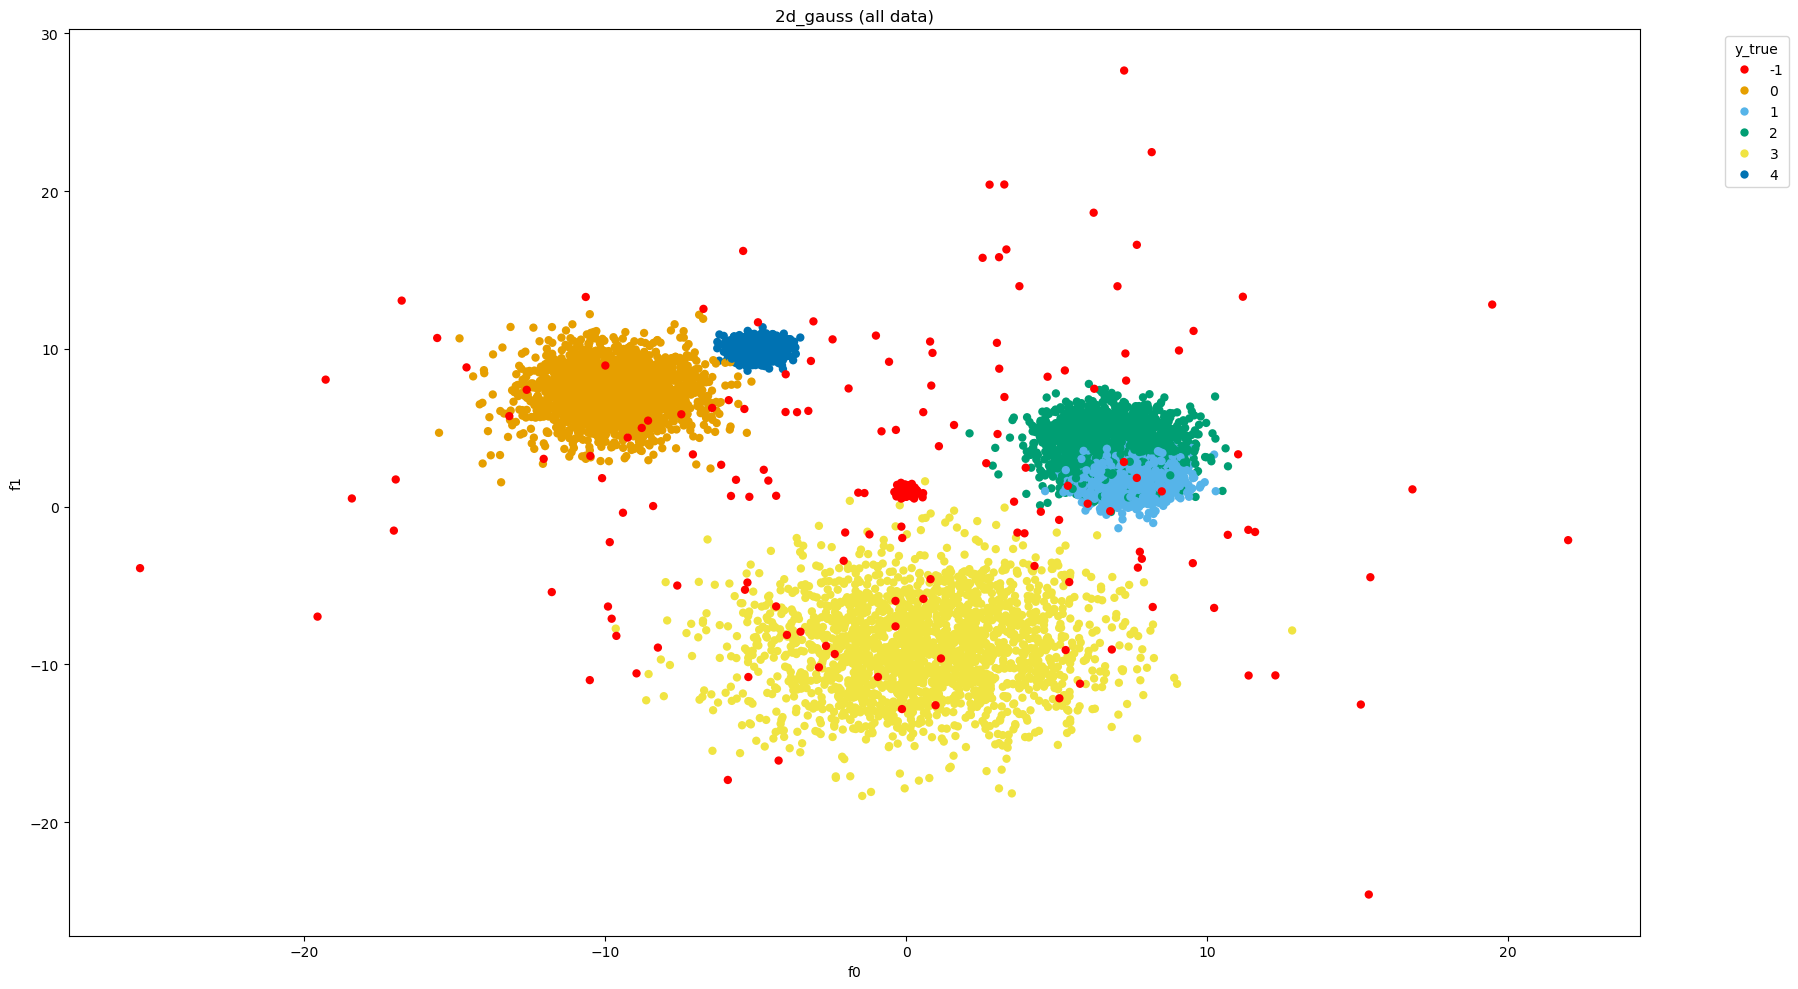

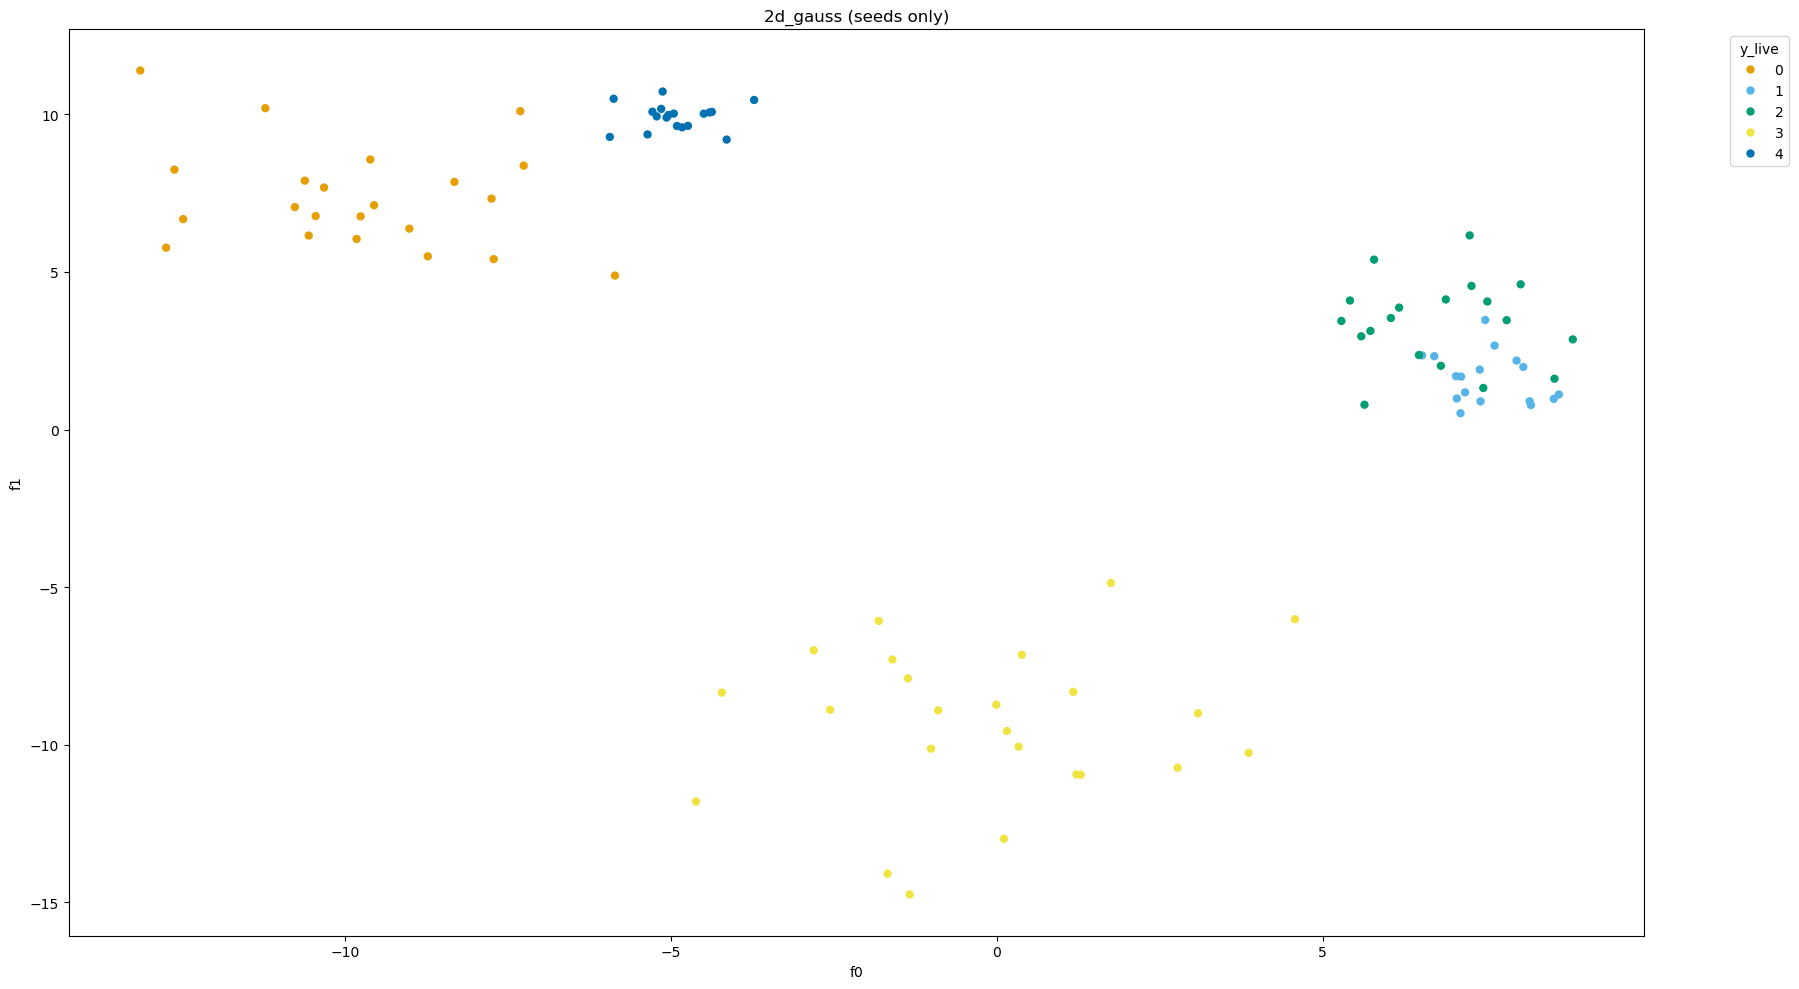

In [43]:
# %% Plot dataset and seeds only separately (anomaly labels are -1 and examples are coloured in red)
plot_clusters(df, feature_columns, label_column='y_true', title=plot_title, show_seeds_only=False)
plot_clusters(df, feature_columns, label_column='y_live', title=dataset_name + ' (seeds only)', show_seeds_only=True)

## Run novel clustering method

             f0         f1  y_true  y_live  novel_method
0      5.512479   3.350089       2      -1             2
1      7.251561   5.776910       2      -1             2
2      6.478803   3.303891       1      -1             2
3     -3.403470  -9.173480       3      -1             3
4      8.002843   1.613259       1      -1             1
...         ...        ...     ...     ...           ...
10295  3.083459  15.811671      -1      -1            -1
10296 -2.667193  -8.823478      -1      -1             3
10297 -0.329665   0.769937      -1      -1            -1
10298 -0.076375   0.855410      -1      -1            -1
10299  0.090215   0.780014      -1      -1            -1

[10300 rows x 5 columns]


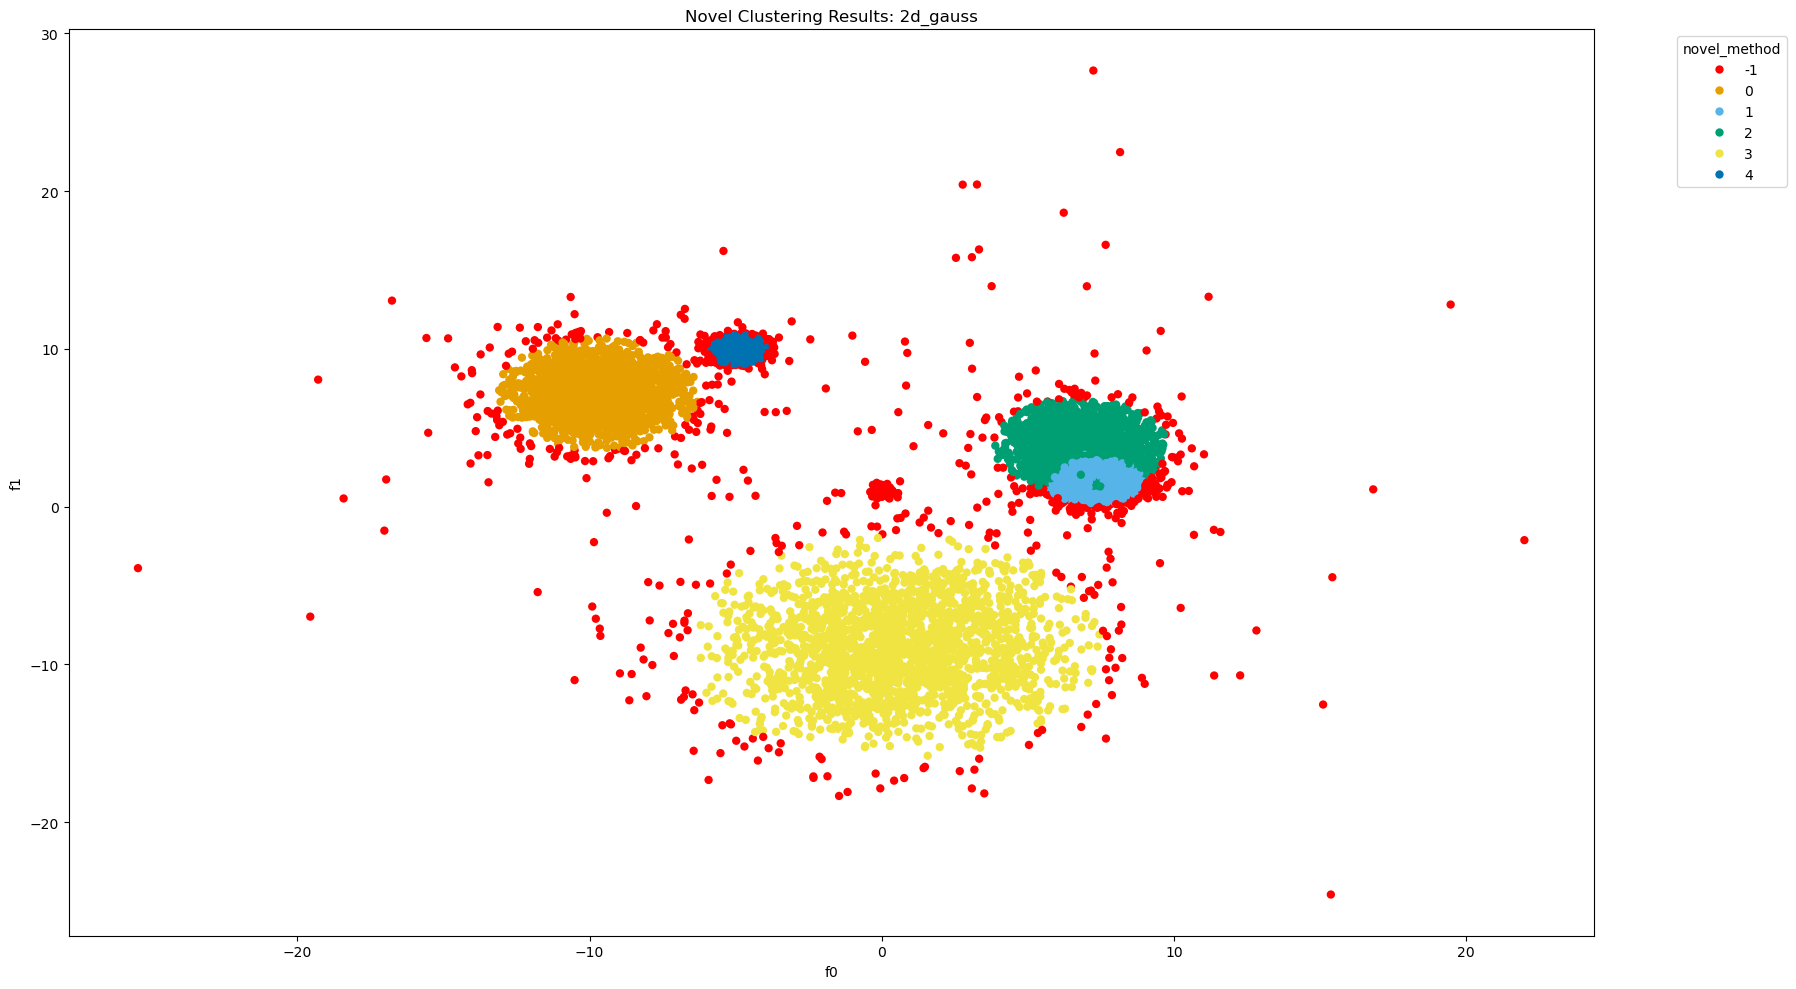

In [44]:
# run the novel clustering algorithm
# ensure dataframe has 'y_live' column of partially labelled data for semi-supervised clustering
df_c = df.copy()
df_novel = novel_clustering(df_c, feature_columns, seeds='y_live')
df['novel_method'] = df_novel['novel_method']
print(df_novel)
plot_clusters(df_novel, feature_columns, label_column='novel_method', title="Novel Clustering Results: " + dataset_name, show_seeds_only=False);

## Seeded k-means method

             f0         f1  y_true  y_live  novel_method  SeededKMeans
0      5.512479   3.350089       2      -1             2             2
1      7.251561   5.776910       2      -1             2             2
2      6.478803   3.303891       1      -1             2             2
3     -3.403470  -9.173480       3      -1             3             3
4      8.002843   1.613259       1      -1             1             1
...         ...        ...     ...     ...           ...           ...
10295  3.083459  15.811671      -1      -1            -1             4
10296 -2.667193  -8.823478      -1      -1             3             3
10297 -0.329665   0.769937      -1      -1            -1             2
10298 -0.076375   0.855410      -1      -1            -1             2
10299  0.090215   0.780014      -1      -1            -1             2

[10300 rows x 6 columns]


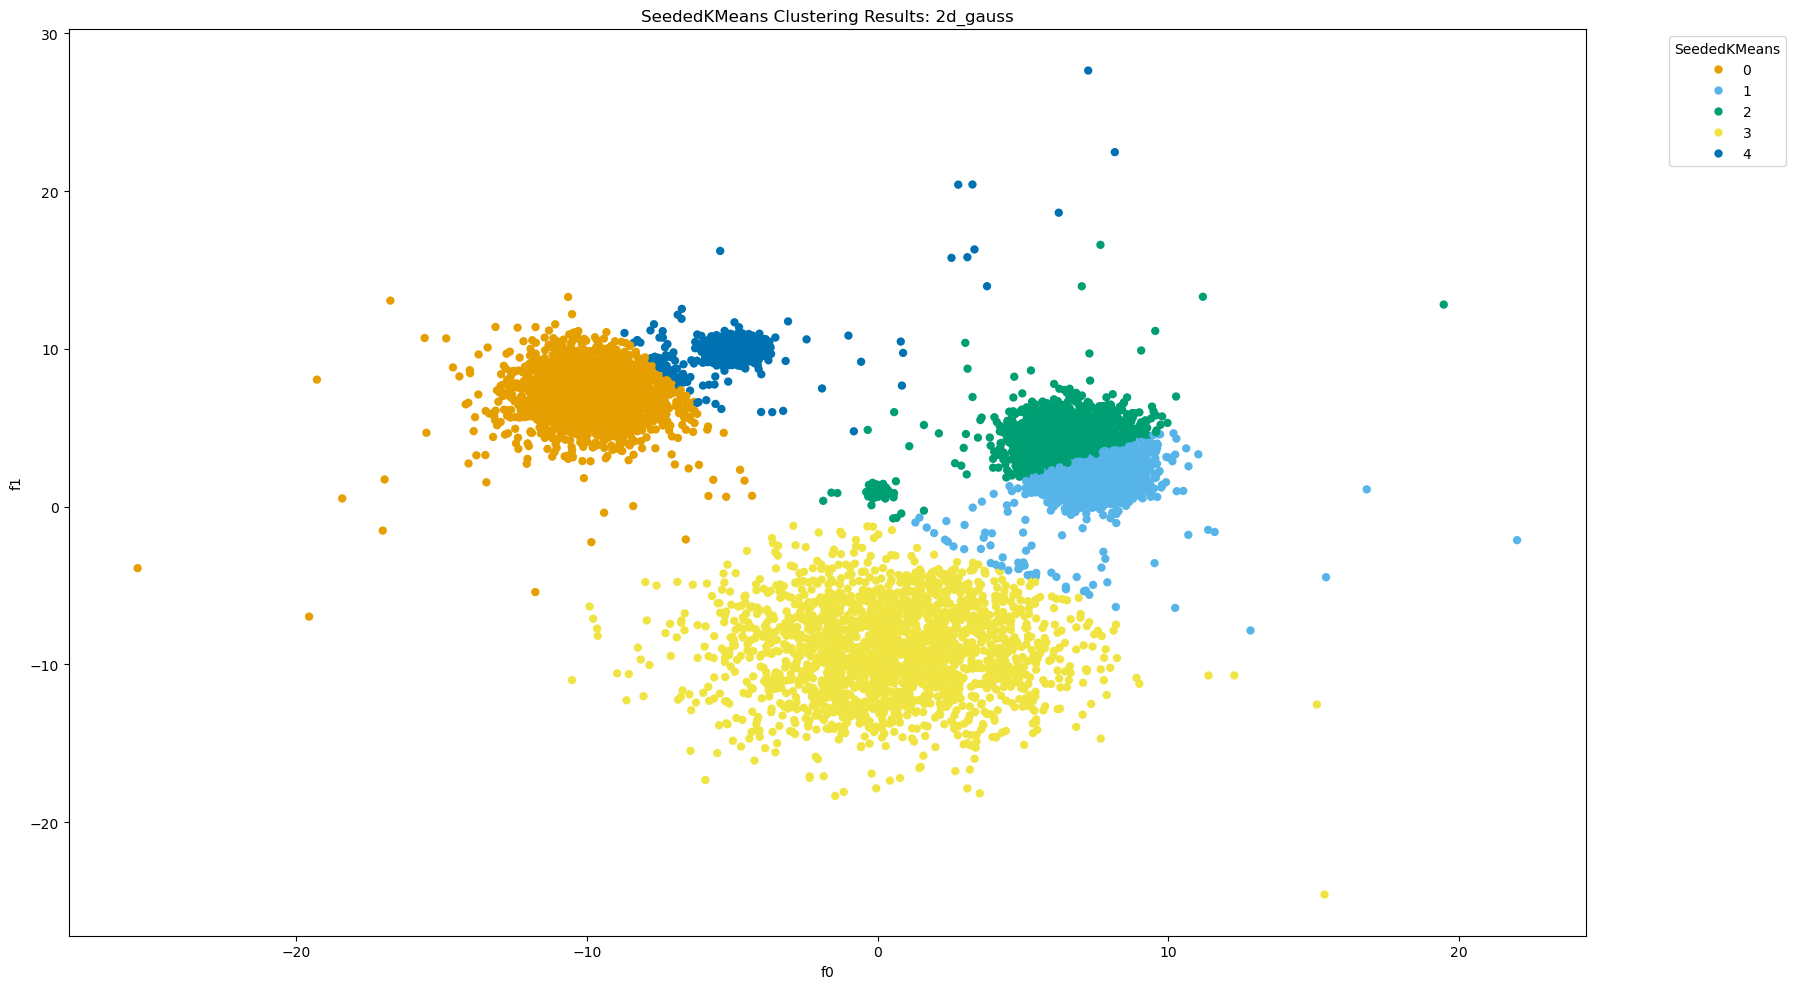

In [45]:
df_c = df.copy()
df_seeded_k_means = seeded_k_means_clustering(df_c, feature_columns, target_column='y_true', seeds='y_live', n_clusters=num_clusters, random_state=0, remap_labels=True)
df['SeededKMeans'] = df_seeded_k_means['SeededKMeans']
print(df_seeded_k_means)
plot_clusters(df_seeded_k_means, feature_columns, label_column='SeededKMeans', title="SeededKMeans Clustering Results: " + dataset_name, show_seeds_only=False)

## K-means clustering method

             f0         f1  y_true  y_live  novel_method  SeededKMeans  KMeans
0      5.512479   3.350089       2      -1             2             2       1
1      7.251561   5.776910       2      -1             2             2       1
2      6.478803   3.303891       1      -1             2             2       1
3     -3.403470  -9.173480       3      -1             3             3       3
4      8.002843   1.613259       1      -1             1             1       1
...         ...        ...     ...     ...           ...           ...     ...
10295  3.083459  15.811671      -1      -1            -1             4       4
10296 -2.667193  -8.823478      -1      -1             3             3       3
10297 -0.329665   0.769937      -1      -1            -1             2       1
10298 -0.076375   0.855410      -1      -1            -1             2       1
10299  0.090215   0.780014      -1      -1            -1             2       1

[10300 rows x 7 columns]


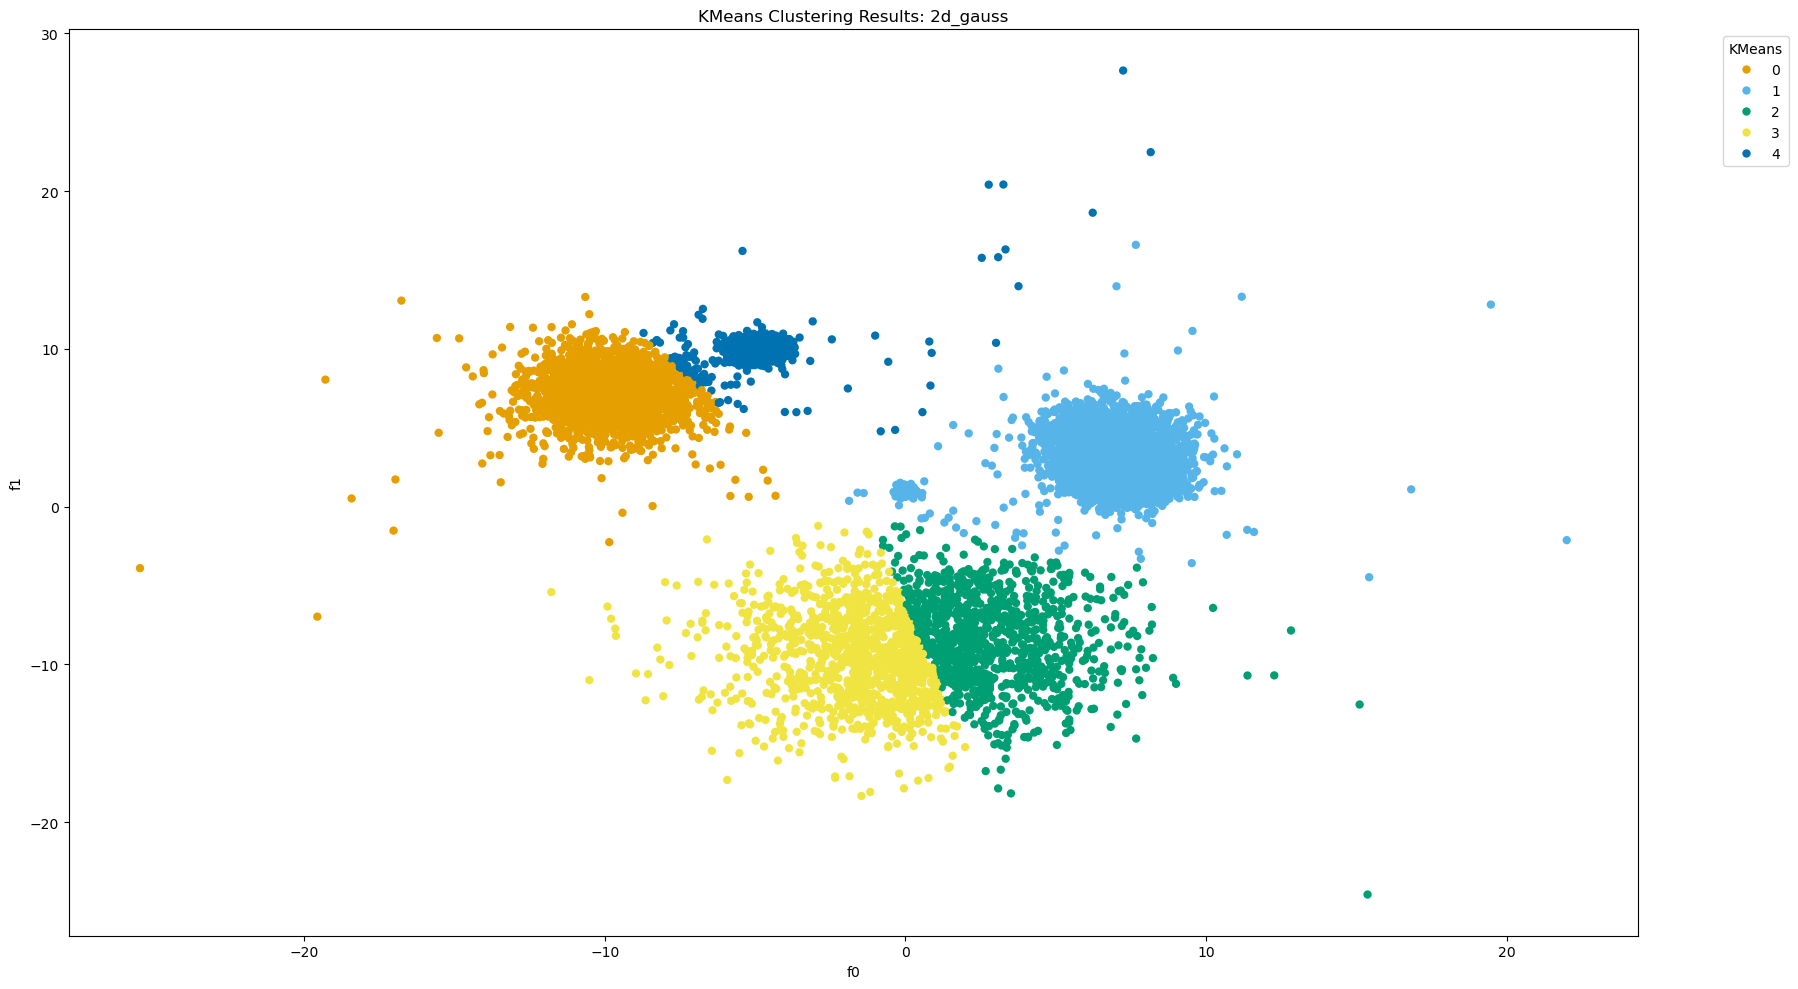

In [46]:
df_c = df.copy()
df_k_means = kmeans_clustering(df_c, feature_columns, target_column='y_true', n_clusters=num_clusters, random_state=0, remap_labels=True)
df['KMeans'] = df_k_means['KMeans']
print(df_k_means)
plot_clusters(df_k_means, feature_columns, label_column='KMeans', title="KMeans Clustering Results: " + dataset_name, show_seeds_only=False)

## DBSCAN clustering method

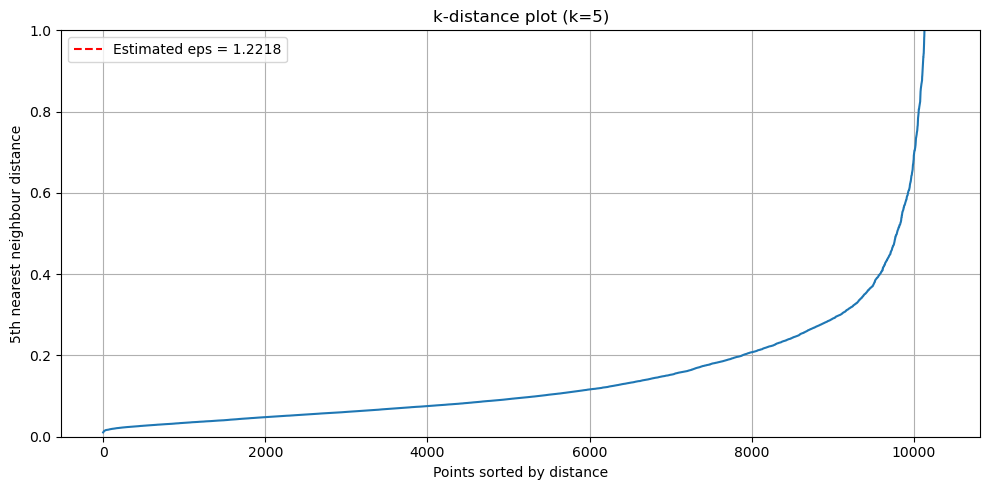

Estimated eps: 1.2218442552594322


In [47]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

def estimate_eps(df, feature_columns, k=5, zoom_ymax=2.0, detect_knee=True):
    """
    Estimate a good eps value for DBSCAN using the k-distance method.

    Parameters:
    - df: DataFrame containing your data.
    - feature_columns: list of feature column names (1D or 2D).
    - k: number of neighbours (min_samples = k).
    - zoom_ymax: max Y limit to zoom into the k-distance plot.
    - detect_knee: whether to automatically find the elbow point.

    Returns:
    - eps: Estimated eps value.
    """

    X = df[feature_columns].values

    # Fit NearestNeighbors
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(X)
    distances, _ = nbrs.kneighbors(X)

    # Sort the k-th distance (k-1 index since indexing starts at 0)
    k_distances = np.sort(distances[:, k - 1])

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(k_distances)
    plt.ylim(0, zoom_ymax)
    plt.title(f'k-distance plot (k={k})')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{k}th nearest neighbour distance')

    eps = None
    if detect_knee:
        knee_locator = KneeLocator(
            range(len(k_distances)),
            k_distances,
            curve='convex',
            direction='increasing'
        )
        eps = k_distances[knee_locator.knee] if knee_locator.knee is not None else None
        if eps:
            plt.axhline(y=eps, color='red', linestyle='--', label=f"Estimated eps = {eps:.4f}")
            plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return eps

eps = estimate_eps(df, feature_columns=feature_columns, k=5, zoom_ymax=1.0, detect_knee=True)
print(f"Estimated eps: {eps}")


             f0         f1  y_true  y_live  novel_method  SeededKMeans  \
0      5.512479   3.350089       2      -1             2             2   
1      7.251561   5.776910       2      -1             2             2   
2      6.478803   3.303891       1      -1             2             2   
3     -3.403470  -9.173480       3      -1             3             3   
4      8.002843   1.613259       1      -1             1             1   
...         ...        ...     ...     ...           ...           ...   
10295  3.083459  15.811671      -1      -1            -1             4   
10296 -2.667193  -8.823478      -1      -1             3             3   
10297 -0.329665   0.769937      -1      -1            -1             2   
10298 -0.076375   0.855410      -1      -1            -1             2   
10299  0.090215   0.780014      -1      -1            -1             2   

       KMeans  DBSCAN  
0           1       0  
1           1       0  
2           1       0  
3           3  

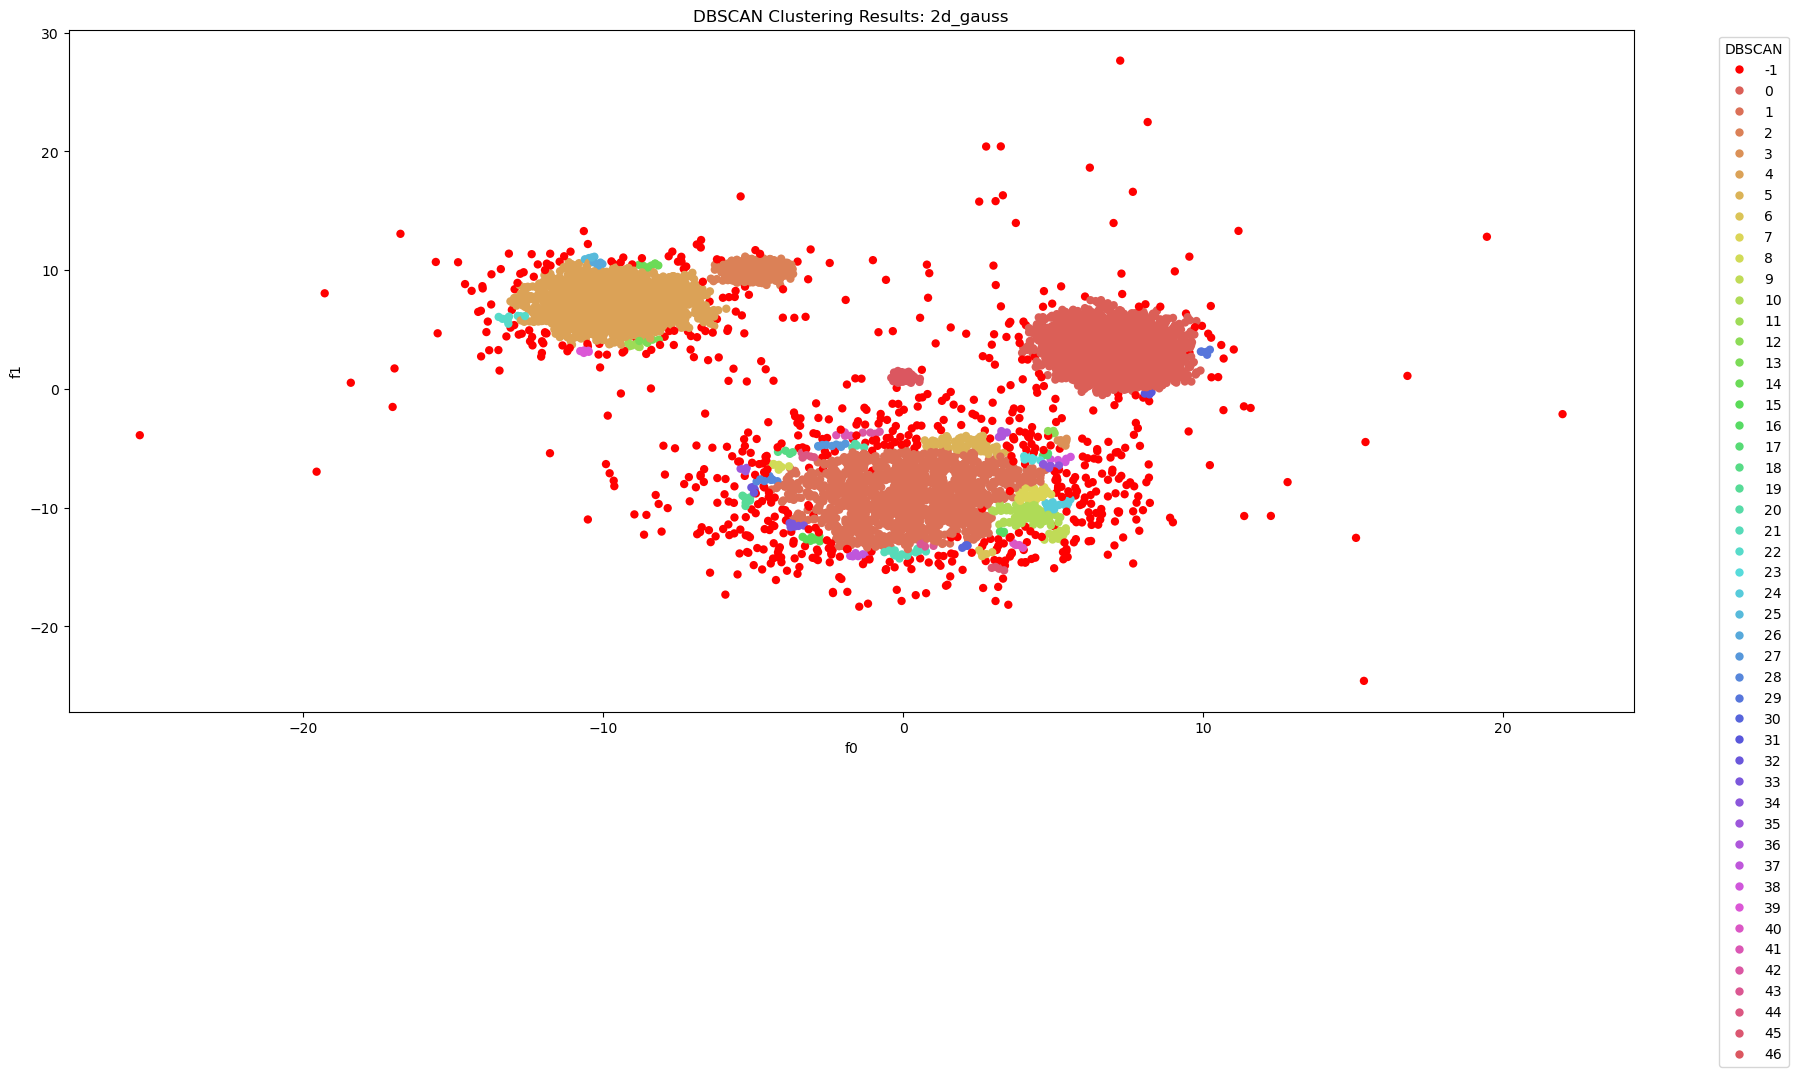

In [48]:
# eps selected as according to paper visually to be 0.1
# knee locator suggests 1
# min_samples = number_of_dimensions + 1 = 4
# sensitive to parameters eps and min_samples
df_c = df.copy()
df_dbscan = dbscan_clustering(df_c, feature_columns, target_column='y_true', eps=0.3, min_samples=4, remap_labels=False)
df['DBSCAN'] = df_dbscan['DBSCAN']
print(df_dbscan)
plot_clusters(df_dbscan, feature_columns, label_column='DBSCAN', title="DBSCAN Clustering Results: " + dataset_name, show_seeds_only=False)

# Clustering Evaluation Metrics

In [49]:
# Automatically determine enabled clustering methods from flags
clustering_methods = ['novel_method', 'SeededKMeans', 'KMeans', 'DBSCAN']

# Define clustering quality metrics requiring ground truth
supervised_metrics = {
    'Accuracy': compute_accuracy,
    'Purity': compute_purity,
    'Homogeneity': compute_homogeneity,
    'Completeness': compute_completeness,
    'V-Measure': compute_v_measure,
    'NMI': compute_nmi,
    'ARI': compute_ari,
    'FMI': compute_fmi,
}

# Compute all metrics in one nested dictionary: {algorithm: {metric: value}}
supervised_results = {
    method: {
        metric: func(df, true_col='y_true', pred_col=method)
        for metric, func in supervised_metrics.items()
    }
    for method in clustering_methods
}

# Convert to DataFrame
supervised_metrics_df = pd.DataFrame.from_dict(supervised_results, orient='index')

# Move algorithm names to a column
supervised_metrics_df.reset_index(inplace=True)
supervised_metrics_df.rename(columns={'index': 'Algorithm'}, inplace=True)

# Add dataset name
supervised_metrics_df['Dataset'] = dataset_name

# Output and save
print("\nSupervised Clustering Metrics:")
metric_cols = list(supervised_metrics.keys())

styled_df = (
    supervised_metrics_df.style
    .highlight_max(subset=metric_cols, axis=0, props='font-weight: bold;')
    .background_gradient(subset=metric_cols, cmap='RdYlGn', axis=0)
    .format(precision=4)
)

styled_df


Supervised Clustering Metrics:


,Algorithm,Accuracy,Purity,Homogeneity,Completeness,V-Measure,NMI,ARI,FMI,Dataset
0,novel_method,0.9383,0.9383,0.8928,0.8928,0.8928,0.8928,0.8684,0.8947,2d_gauss
1,SeededKMeans,0.9256,0.9256,0.8610,0.8655,0.8632,0.8632,0.8385,0.8711,2d_gauss
2,KMeans,0.6956,0.7909,0.8007,0.8780,0.8376,0.8376,0.6985,0.7737,2d_gauss
3,DBSCAN,0.0007,0.7914,0.8172,0.8477,0.8322,0.8322,0.7243,0.7983,2d_gauss
